In [22]:
from __future__ import print_function
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np

#import astropy.io.fits as pyfits
import pyfits, time, itertools, random, os, sys, glob, re

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
import seaborn as sns; sns.set()

%matplotlib inline

## Multiple Stars, Average Spectra (Updated June 5th)

In [23]:
star_names = np.genfromtxt("short_star_names.txt", dtype='str')

short_stars_rv = np.loadtxt("short_RVs.txt")
short_stars_photometry = np.loadtxt("short_photometry.txt")
#print(short_stars_rv)

In [24]:
stars_S_avgs = []
stars_S_avgs_err = []
stars_RHK_PRIME_avgs = []
stars_RHK_PRIME_avgs_err = []

#star_names = ["TYC1265-1118-1"]
#star_names = ["2MASSJ04184702+1321585"]
#star_names = ["2MASSJ03315564-4359135"]
#star_names = ["G80-21"]
#star_names = ["GJ176"]

for j in range(len(star_names)):
    print(star_names[j])
    
    #calculating stellar ccf (Astudillo-Defru 2017 equation 9 and table 1)
    #ALL COEFFS ARE FOR V-K COLOR
    ccf_c0 = -0.005
    ccf_c1 = 0.071
    ccf_c2 = -0.713 # +/- 0.006
    ccf_c3 = 0.973 # +/- 0.006
    
    R_c0 = -0.003
    R_c1 = 0.069
    R_c2 = -0.717 # +/- 0.003
    R_c3 = -3.498 # +/- 0.004
    
    V = short_stars_photometry[j][2]
    V_err = short_stars_photometry[j][3]
    K = short_stars_photometry[j][0]
    K_err = short_stars_photometry[j][1]
    V_K = V-K

    #QUESTION: should "log" in the paper mean natural log???
    Ccf = 10**(ccf_c0*(V_K)**3 + ccf_c1*(V_K)**2 + ccf_c2*(V_K) + ccf_c3)
    Rphot = 10**(R_c0*(V_K)**3 + R_c1*(V_K)**2 + R_c2*(V_K) + R_c3)
    #print(Rphot)

    spectra = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)
    
    #speed of light, target star RV in meters per second
    c = 299792458e10
    RV = short_stars_rv[j] * (10**13)

    all_S = []
    all_RHK_PRIME = []
    all_err_S = []
    all_err_RHK_PRIME = []

    for i in range(len(spectra)): #range(0,55):
        
        if "ADP" in spectra[i]:
            hdu = pyfits.open(spectra[i])
            #print(spectra[i])
            #print(i)

            wave = hdu[1].data[0][0] 
            flux = hdu[1].data[0][1]
            err = np.nan_to_num(hdu[1].data[0][2])
            #print("HARPS Error Array: ", err)

            wave = wave / (1 + RV / c)
            
            #TESTING FOR RANGES (PARTICULARLY FOR UVES)
            if (np.min(wave)>3891 or np.max(wave)<4011):
                print("Spectrum range not inclusive of all regions: ", spectra[i])
                print(wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)

            else:
                #fnding mean V continuum flux
                V_idx_cont = np.where((wave > (3901 - 10)) & (wave < (3901 + 10)))[0]
                V_sub_cont = flux[V_idx_cont]
                V_err_cont = np.std(V_sub_cont)
                V_mean_cont = np.mean(V_sub_cont)

                #finding mean K line flux
                K_idx_wave = np.where((wave > (3933.6614 - 1.09/.5)) & (wave < (3933.6614 + 1.09/.5)))[0]
                K_sub_flux = flux[K_idx_wave]
                K_err_flux = err[K_idx_wave] 
                K_mean_flux = np.mean(K_sub_flux)

                #finding mean H line flux
                H_idx_wave = np.where((wave > (3968.4673 - 1.09/.5)) & (wave < (3968.4673 + 1.09/.5)))[0]
                H_sub_flux = flux[H_idx_wave]
                H_err_flux = err[H_idx_wave] 
                H_mean_flux = np.mean(H_sub_flux)

                #finding mean R continuum flux                      
                R_idx_cont = np.where(((wave > (4001 - 10)) & (wave < (4001 + 10))))[0]
                R_sub_cont = flux[R_idx_cont]
                R_err_cont = np.std(R_sub_cont)
                R_mean_cont = np.mean(R_sub_cont)

                #S INDEX!!!
                S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
                S = S_instrument_calibrated

                #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
                Rhk = 1.887e-4 * Ccf * S
                #print(Rhk)
                RHK_PRIME = Rhk - Rphot
                #print(RHK_PRIME)

                func_var_S = np.array([(R_err_cont**2)*((1/R_mean_cont**2)**2)+(V_err_cont**2)*((1/V_mean_cont**2)**2)])
                err_S = np.sqrt(np.sum(func_var_S))
                func_var_RHK = (err_S**2) * (Ccf * 1.884e-4)**2  #technically need to include Ccf error too!!!!!
                err_RHK_PRIME = np.sqrt(np.sum(func_var_RHK))

                """plt.figure(figsize=(16,4))
                plt.plot(wave,flux)
                #plt.xlim(3880,4020)
                plt.xlim(3920,3940)
                #plt.xlim(3925,3975)
                plt.ylim(-100,1000)
                plt.axvline(3968.4673) #+ 3968.4673 * RV / c )
                plt.axvline(3968.4673 + 1.09/2) # + 3968.4673 * RV / c )
                plt.axvline(3968.4673 - 1.09/2) # + 3968.4673 * RV / c )
                plt.axvline(3933.6614) #+ 3933.6614 * RV / c )
                plt.axvline(3933.6614 + 1.09/2) # + 3933.6614 * RV / c )
                plt.axvline(3933.6614 - 1.09/2) # + 3933.6614 * RV / c )
                plt.show()"""

                #TESTING FOR NOISY SPECTRA
                if H_mean_flux < 0.0:
                    print(spectra[i], " H flux negative: ", H_mean_flux)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
                if K_mean_flux < 0.0:
                    print(spectra[i], " K flux negative: ", K_mean_flux)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
                if V_mean_cont < 0.0:
                    print(spectra[i], " V flux negative: ", V_mean_cont)
                if R_mean_cont < 0.0:
                    print(spectra[i], " R flux negative: ", R_mean_cont)
                if S < 0.0:
                    print(spectra[i], " S INDEX negative: ", S)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)

        #######################################################################
        
        #HIRES TARGET SPECTRA
        if "HI" in spectra[i]:
            merged_file = glob.glob("%s/HI*MERGED.txt" % spectra[i])
            wave = np.genfromtxt(merged_file[0], usecols=0)
            flux = np.genfromtxt(merged_file[0], usecols=1)
            
            wave = wave / (1 + RV / c)
            #print("HI ", wave)
            
            #TESTING FOR RANGES
            if (np.min(wave)>3891 or np.max(wave)<4011):
                print("Spectrum range not inclusive of all regions: ", spectra[i])
                print(wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)
                
            else:
                #fnding mean V continuum flux
                V_idx_cont = np.where((wave > (3901 - 10)) & (wave < (3901 + 10)))[0]
                V_sub_cont = flux[V_idx_cont]
                V_err_cont = np.std(V_sub_cont)
                V_mean_cont = np.mean(V_sub_cont)

                #finding mean K line flux
                K_idx_wave = np.where((wave > (3933.6614 - 1.09/.5)) & (wave < (3933.6614 + 1.09/.5)))[0]
                K_sub_flux = flux[K_idx_wave]
                K_err_flux = err[K_idx_wave] 
                K_mean_flux = np.mean(K_sub_flux)

                #finding mean H line flux
                H_idx_wave = np.where((wave > (3968.4673 - 1.09/.5)) & (wave < (3968.4673 + 1.09/.5)))[0]
                H_sub_flux = flux[H_idx_wave]
                H_err_flux = err[H_idx_wave] 
                H_mean_flux = np.mean(H_sub_flux)

                #finding mean R continuum flux                      
                R_idx_cont = np.where(((wave > (4001 - 10)) & (wave < (4001 + 10))))[0]
                R_sub_cont = flux[R_idx_cont]
                R_err_cont = np.std(R_sub_cont)
                R_mean_cont = np.mean(R_sub_cont)

                #S INDEX!!!
                S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
                S = S_instrument_calibrated

                #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
                Rhk = 1.887e-4 * Ccf * S
                #print(Rhk)
                RHK_PRIME = Rhk - Rphot
                #print(RHK_PRIME)

                #TESTING FOR NOISY SPECTRA
                if H_mean_flux < 0.0:
                    print(spectra[i], " H flux negative: ", H_mean_flux)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
                if K_mean_flux < 0.0:
                    print(spectra[i], " K flux negative: ", K_mean_flux)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
                if V_mean_cont < 0.0:
                    print(spectra[i], " V flux negative: ", V_mean_cont)
                if R_mean_cont < 0.0:
                    print(spectra[i], " R flux negative: ", R_mean_cont)
                if S < 0.0:
                    print(spectra[i], " S INDEX negative: ", S)
                    S = "nan"
                    RHK_PRIME = "nan"
                    err_S = "nan"
                    err_RHK_PRIME = "nan"
        
                func_var_S = np.array([(R_err_cont**2)*((1/R_mean_cont**2)**2)+(V_err_cont**2)*((1/V_mean_cont**2)**2)])
                err_S = np.sqrt(np.sum(func_var_S))
                func_var_RHK = (err_S**2) * (Ccf*1.887e-4)**2 #technically need to include Ccf error too!!!!!
                err_RHK_PRIME = np.sqrt(np.sum(func_var_RHK))
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)

    output = np.column_stack((np.nan_to_num(np.array(all_S).astype("float")), 
                          np.nan_to_num(np.array(all_err_S).astype("float")), 
                          np.nan_to_num(np.array(all_RHK_PRIME).astype("float")),
                          np.nan_to_num(np.array(all_err_RHK_PRIME).astype("float"))))
    #print(output)
    np.savetxt("Results/%s_spectra_cahk.txt" % star_names[j], output)
    
    #AVERAGING CALCULATED INDEX VALUES FOR EACH STAR
    #stars_S_avgs.append(np.nanmean(np.array(all_S).astype("float")))
    #stars_S_avgs_err.append(np.nanstd(np.array(all_S).astype("float"), ddof=1))
    #stars_RHK_PRIME_avgs.append(np.nanmean(np.array(all_RHK_PRIME).astype("float")))
    #stars_RHK_PRIME_avgs_err.append(np.nanstd(np.array(all_RHK_PRIME).astype("float"), ddof=1))

    non_nan = np.where(np.logical_not(np.logical_and(np.isnan(np.array(all_S).astype("float")), 
                                                     np.isnan(np.array(all_RHK_PRIME).astype("float")))))[0]
    #non_nan_RHK = np.where(np.logical_not(np.isnan(all_RHK_PRIME)))[0]
    all_S = np.array(all_S).astype("float")
    all_RHK_PRIME = np.array(all_RHK_PRIME).astype("float")
    all_err_S = np.array(all_err_S).astype("float")
    all_err_RHK_PRIME = np.array(all_err_RHK_PRIME).astype("float")
    #print(all_RHK_PRIME)
    #print(all_err_RHK_PRIME)
    
    if len(non_nan) != 0:
        stars_S_avgs.append(np.average(all_S[non_nan], weights=1/((all_err_S[non_nan])**2))) #np.nanmean takes average while ignoring nan
        stars_S_avgs_err.append(1/np.sum(1/((all_err_S[non_nan])**2)))
        stars_RHK_PRIME_avgs.append(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2)))
        stars_RHK_PRIME_avgs_err.append(1/np.sum(1/((all_err_RHK_PRIME[non_nan])**2)))
        print("Average S: ", np.average(all_S[non_nan], weights=1/((all_err_S[non_nan])**2)),
              "Error: ", 1/np.sum(1/((all_err_S[non_nan])**2)))
        #print("Average log(R'HK): ", np.log10(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2))),
              #"Error: ", (1/np.sum(1/((all_err_RHK_PRIME[non_nan])**2)))/np.log10(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2))))
        #SHOULD THIS ERROR INCLUDE NATURAL LOG AS WELL?
        print("Average log(R'HK): ", np.log10(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2))),
              "Error: ", 0.434*np.sqrt(1/np.sum(1/((all_err_RHK_PRIME[non_nan])**2)))/np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2)))
    else:
        stars_S_avgs.append("nan") #np.nanmean takes average while ignoring nan
        stars_S_avgs_err.append("nan")
        stars_RHK_PRIME_avgs.append("nan")
        stars_RHK_PRIME_avgs_err.append("nan")
        print("Average S: nan", "Error: nan")
        print("Average log(R'HK): nan", "Error: nan")
        
print("Star names: ", star_names)
print("S averages for each star: ", stars_S_avgs)
print("R'HK averages for each star: ", stars_RHK_PRIME_avgs)
print("log(R'HK) averages for each star: ", np.log10(np.nan_to_num(np.array(stars_RHK_PRIME_avgs).astype("float"))))

GJ176
Average S:  0.740773260207 Error:  1.34624566874e-06
Average log(R'HK):  -5.21049019273 Error:  0.00098464801463
GJ667C
Average S:  0.304512994107 Error:  1.79124117554e-08
Average log(R'HK):  -5.94558383696 Error:  0.000709957869773
GJ581
Average S:  0.512215730388 Error:  1.16040818359e-05
Average log(R'HK):  -5.64545355106 Error:  0.00566023843102
GJ1214
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  H flux negative:  -0.875228
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  K flux negative:  -0.584263
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  V flux negative:  -1.44044
Spectra/GJ1214/ADP.2014-09-26T16:54:55.927.fits  V flux negative:  -0.148809
Average S:  0.69656565846 Error:  0.00808269427118
Average log(R'HK):  -5.99502437949 Error:  0.119413541396
GJ832
Spectrum range not inclusive of all regions:  Spectra/GJ832/HI.20091203.16313_1.fits
[ 3926.859638    3926.86963757  3926.87963715 ...,  4927.33692144
  4927.34692101  4927.35692058]
Average S:  0.488546530819 Er

/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:284: RuntimeWarning: invalid value encountered in log10


Spectrum range not inclusive of all regions:  Spectra/2MASSJ00240899-6211042/ADP.2015-10-14T11:29:31.410.fits
[ 4726.3716028   4726.39999913  4726.42839547 ...,  6834.8787634
  6834.91284764  6834.94693188]
Average S:  2.45951494204 Error:  1.37890338852e-06
Average log(R'HK):  -4.37357660992 Error:  0.000226165999185
2MASSJ01521830-5950168
Spectrum range not inclusive of all regions:  Spectra/2MASSJ01521830-5950168/ADP.2015-09-15T10:37:13.003.fits
[ 4726.34172528  4726.37024412  4726.39876296 ...,  6834.79316372
  6834.82729076  6834.8614178 ]
Spectrum range not inclusive of all regions:  Spectra/2MASSJ01521830-5950168/ADP.2015-10-14T10:52:58.557.fits
[ 4726.3314236   4726.35993361  4726.38844361 ...,  6834.78606044
  6834.82019375  6834.85432707]
Spectrum range not inclusive of all regions:  Spectra/2MASSJ01521830-5950168/ADP.2015-10-14T10:56:24.207.fits
[ 4726.33748981  4726.3659403   4726.39439079 ...,  6834.80835689
  6834.84246919  6834.87658149]
Average S:  2.98437785221 Error: 

/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:297: RuntimeWarning: divide by zero encountered in log10
/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:297: RuntimeWarning: invalid value encountered in log10


In [18]:
print(err_S)
print(np.sqrt((err_S**2) * (Ccf*1.887e-4)**2))
print(err_RHK_PRIME)

0.0229644229832
2.77003634303e-07
7.96938854929e-05


In [302]:
wave = hdu[1].data
#print(wave)
print(K_idx_wave)
flux = hdu[1].data[1]
print(wave, flux)
print(len(flux))
print(spectra[i])
print(V_idx_cont[0])
hdu[1].header

[13396 13397 13398 13399 13400 13401 13402 13403 13404 13405 13406 13407
 13408 13409 13410 13411 13412 13413 13414 13415 13416 13417 13418 13419
 13420 13421 13422 13423 13424 13425 13426 13427 13428 13429 13430 13431
 13432 13433 13434 13435 13436 13437 13438 13439 13440 13441 13442 13443
 13444 13445 13446 13447 13448 13449 13450 13451 13452 13453 13454 13455
 13456 13457 13458 13459 13460 13461 13462 13463 13464 13465 13466 13467
 13468 13469 13470 13471 13472 13473 13474 13475 13476 13477 13478 13479
 13480 13481 13482 13483 13484 13485 13486 13487 13488 13489 13490 13491
 13492 13493 13494 13495 13496 13497 13498 13499 13500 13501 13502 13503
 13504 13505 13506 13507 13508 13509 13510 13511 13512 13513 13514 13515
 13516 13517 13518 13519 13520 13521 13522 13523 13524 13525 13526 13527
 13528 13529 13530 13531 13532 13533 13534 13535 13536 13537 13538 13539
 13540 13541 13542 13543 13544 13545 13546 13547 13548 13549 13550 13551
 13552 13553 13554 13555 13556 13557 13558 13559 13

IndexError: Index out of bounds

In [303]:
output = np.column_stack((np.nan_to_num(np.array(stars_S_avgs).astype("float")), 
                          np.nan_to_num(np.array(stars_S_avgs_err).astype("float")), 
                          np.nan_to_num(np.array(stars_RHK_PRIME_avgs).astype("float")),
                          np.nan_to_num(np.array(stars_RHK_PRIME_avgs_err).astype("float"))))
#print(output)
np.savetxt("Results/short_cahk_s_rhk.txt", output)

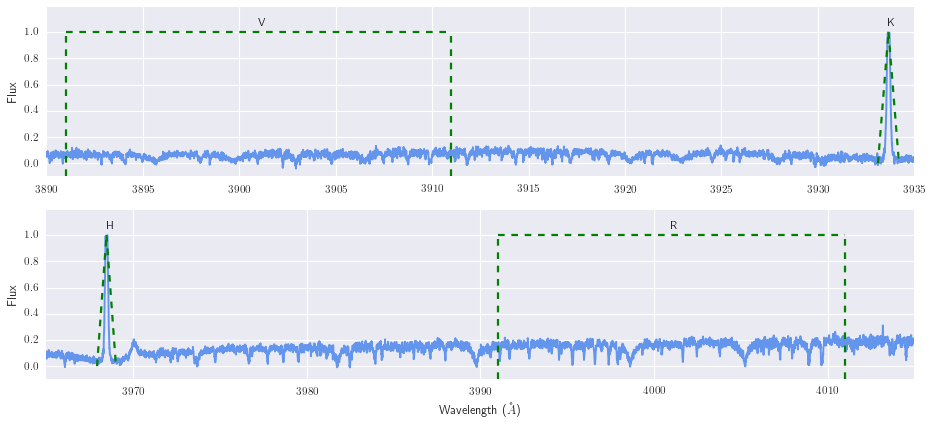

In [151]:
#print(wave[K_idx_wave])

K = 3933.6614
H = 3968.4673

#x=[6562.8-0.24312788/2, 6562.8+0.24312788/2, 6562.8+0.24312788/2, 6562.8-0.24312788/2]
#y=[mean_cont, mean_cont, 0, 0]

plt.figure(figsize=(14,6))

plt.subplot(211)
plt.xlim(3890,3935)
plt.plot(wave, flux/np.max(K_sub_flux), color="cornflowerblue")
plt.ylim(-0.1,1.19)
plt.plot((3891, 3911), (1, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((3891, 3891), (-0.1, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((3911, 3911), (-0.1, 1), linewidth=2, color = 'green', linestyle="--")
plt.text(3901, 1.05, "V")
plt.plot((K-1.09/2, K), (0, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((K, K+1.09/2), (1,0), linewidth=2, color = 'green', linestyle="--")
plt.text(wave[K_idx_wave][0][np.argmax(K_sub_flux)], 1.05, "K")
plt.ylabel("Flux")

plt.subplot(212)
plt.xlim(3965,4015)
plt.plot(wave, flux/np.max(H_sub_flux), color="cornflowerblue")
plt.ylim(-0.1,1.19)
plt.plot((3991, 4011), (1, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((3991, 3991), (-0.1, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((4011, 4011), (-0.1, 1), linewidth=2, color = 'green', linestyle="--")
plt.text(4001, 1.05, "R")
plt.plot((H-1.09/2, H), (0, 1), linewidth=2, color = 'green', linestyle="--")
plt.plot((H, H+1.09/2), (1,0), linewidth=2, color = 'green', linestyle="--")
plt.text(wave[H_idx_wave][0][np.argmax(H_sub_flux)], 1.05, "H")
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux")

#plt.savefig("Comparisons/CaHK_example.png")
plt.show()

# HARPS AND HIRES (before coadding the spectra!)

In [152]:
stars_S_avgs = []
stars_S_avgs_err = []
stars_RHK_PRIME_avgs = []
stars_RHK_PRIME_avgs_err = []

#star_names = ["TYC1265-1118-1"]
#star_names = ["2MASSJ04184702+1321585"]
#star_names = ["GJ176"]

for j in range(len(star_names)):
    print(star_names[j])
    
    #calculating stellar ccf (Astudillo-Defru 2017 equation 9 and table 1)
    #ALL COEFFS ARE FOR V-K COLOR
    ccf_c0 = -0.005
    ccf_c1 = 0.071
    ccf_c2 = -0.713 # +/- 0.006
    ccf_c3 = 0.973 # +/- 0.006
    
    R_c0 = -0.003
    R_c1 = 0.069
    R_c2 = -0.717 # +/- 0.003
    R_c3 = -3.498 # +/- 0.004
    
    V = short_stars_photometry[j][2]
    V_err = short_stars_photometry[j][3]
    K = short_stars_photometry[j][0]
    K_err = short_stars_photometry[j][1]
    V_K = V-K

    #QUESTION: should "log" in the paper mean natural log???
    Ccf = 10**(ccf_c0*(V_K)**3 + ccf_c1*(V_K)**2 + ccf_c2*(V_K) + ccf_c3)
    Rphot = 10**(R_c0*(V_K)**3 + R_c1*(V_K)**2 + R_c2*(V_K) + R_c3)
    #print(Rphot)

    spectra = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)
    
    #speed of light, target star RV in meters per second
    c = 299792458e10
    RV = short_stars_rv[j] * (10**13)

    all_S = []
    all_RHK_PRIME = []
    all_err_S = []
    all_err_RHK_PRIME = []

    for i in range(len(spectra)): #range(0,55):
        
        if "ADP" in spectra[i]:
            hdu = pyfits.open(spectra[i])
            #print(spectra[i])
            #print(i)

            wave = hdu[1].data[0][0] 
            flux = hdu[1].data[0][1]
            err = np.nan_to_num(hdu[1].data[0][2])
            #print("HARPS Error Array: ", err)

            wave = wave / (1 + RV / c)

            #fnding mean V continuum flux
            V_idx_cont = np.where((wave > (3901 - 10)) & (wave < (3901 + 10)))
            V_sub_cont = flux[V_idx_cont]
            V_err_cont = np.std(V_sub_cont)
            V_mean_cont = np.mean(V_sub_cont)

            #finding mean K line flux
            K_idx_wave = np.array(np.where((wave > (3933.6614 - 1.09/.5)) & (wave < (3933.6614 + 1.09/.5))))
            K_sub_flux = flux[K_idx_wave]
            K_err_flux = err[K_idx_wave] 
            K_mean_flux = np.mean(K_sub_flux)

            #finding mean H line flux
            H_idx_wave = np.array(np.where((wave > (3968.4673 - 1.09/.5)) & (wave < (3968.4673 + 1.09/.5))))
            H_sub_flux = flux[H_idx_wave]
            H_err_flux = err[H_idx_wave] 
            H_mean_flux = np.mean(H_sub_flux)

            #finding mean R continuum flux                      
            R_idx_cont = np.where(((wave > (4001 - 10)) & (wave < (4001 + 10))))
            R_sub_cont = flux[R_idx_cont]
            R_err_cont = np.std(R_sub_cont)
            R_mean_cont = np.mean(R_sub_cont)
            
            #S INDEX!!!
            S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
            S = S_instrument_calibrated
            
            #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
            Rhk = 1.887e-4 * Ccf * S
            #print(Rhk)
            RHK_PRIME = Rhk - Rphot
            #print(RHK_PRIME)
            
            """plt.figure(figsize=(16,4))
            plt.plot(wave,flux)
            #plt.xlim(3880,4020)
            plt.xlim(3920,3940)
            #plt.xlim(3925,3975)
            plt.ylim(-100,1000)
            plt.axvline(3968.4673) #+ 3968.4673 * RV / c )
            plt.axvline(3968.4673 + 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3968.4673 - 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3933.6614) #+ 3933.6614 * RV / c )
            plt.axvline(3933.6614 + 1.09/2) # + 3933.6614 * RV / c )
            plt.axvline(3933.6614 - 1.09/2) # + 3933.6614 * RV / c )
            plt.show()"""
            
            #TESTING FOR NOISY SPECTRA
            if H_mean_flux < 0.0:
                print(spectra[i], " H flux negative: ", H_mean_flux)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            if K_mean_flux < 0.0:
                print(spectra[i], " K flux negative: ", K_mean_flux)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            if V_mean_cont < 0.0:
                print(spectra[i], " V flux negative: ", V_mean_cont)
            if R_mean_cont < 0.0:
                print(spectra[i], " R flux negative: ", R_mean_cont)
            if S < 0.0:
                print(spectra[i], " S INDEX negative: ", S)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            
            #TESTING FOR RANGES (PARTICULARLY FOR UVES)
            if (np.min(wave)>3891 or np.max(wave)<4011):
                print("Spectrum range not inclusive of all regions: ", spectra[i])
                print(wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)
            else:
                func_var_S = np.array([(R_err_cont**2)*((1/R_mean_cont**2)**2)+(V_err_cont**2)*((1/V_mean_cont**2)**2)])
                err_S = np.sqrt(np.sum(func_var_S))
                func_var_RHK = 1.884e-4 * (err_S**2) * Ccf #technically need to include Ccf error too!!!!!
                err_RHK_PRIME = np.sqrt(np.sum(func_var_RHK))
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)

        #######################################################################
        
        #HIRES TARGET SPECTRA
        if "HI" in spectra[i]:
            V_file = glob.glob("%s/HI.*_03_flux.fits" % spectra[i])
            HK_file = glob.glob("%s/HI.*_04_flux.fits" % spectra[i])
            R_file = glob.glob("%s/HI.*_05_flux.fits" % spectra[i])

            V_hdu = pyfits.open(V_file[0])
            HK_hdu = pyfits.open(HK_file[0])
            R_hdu = pyfits.open(R_file[0])

            V_wave = V_hdu[1].data["wave"] / (1 + RV / c)
            V_flux = V_hdu[1].data["flux"]
            
            HK_wave = HK_hdu[1].data["wave"] / (1 + RV / c)
            HK_flux = HK_hdu[1].data["flux"]

            R_wave = R_hdu[1].data["wave"] / (1 + RV / c)
            R_flux = R_hdu[1].data["flux"]
            
            #fnding mean V continuum flux
            V_idx_cont = np.where((V_wave > (3901 - 10)) & (V_wave < (3901 + 10)))
            V_sub_cont = flux[V_idx_cont]
            V_err_cont = np.std(V_sub_cont)
            V_mean_cont = np.mean(V_sub_cont)

            #finding mean K line flux
            K_idx_wave = np.array(np.where((HK_wave > (3933.6614 - 1.09/.5)) & (HK_wave < (3933.6614 + 1.09/.5))))
            K_sub_flux = flux[K_idx_wave]
            K_err_flux = err[K_idx_wave] 
            K_mean_flux = np.mean(K_sub_flux)

            #finding mean H line flux
            H_idx_wave = np.array(np.where((HK_wave > (3968.4673 - 1.09/.5)) & (HK_wave < (3968.4673 + 1.09/.5))))
            H_sub_flux = flux[H_idx_wave]
            H_err_flux = err[H_idx_wave] 
            H_mean_flux = np.mean(H_sub_flux)

            #finding mean R continuum flux                      
            R_idx_cont = np.where(((R_wave > (4001 - 10)) & (R_wave < (4001 + 10))))
            R_sub_cont = flux[R_idx_cont]
            R_err_cont = np.std(R_sub_cont)
            R_mean_cont = np.mean(R_sub_cont)
            
            #S INDEX!!!
            S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
            S = S_instrument_calibrated

            #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
            Rhk = 1.887e-4 * Ccf * S
            #print(Rhk)
            RHK_PRIME = Rhk - Rphot
            #print(RHK_PRIME)

            #TESTING FOR NOISY SPECTRA
            if H_mean_flux < 0.0:
                print(spectra[i], " H flux negative: ", H_mean_flux)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            if K_mean_flux < 0.0:
                print(spectra[i], " K flux negative: ", K_mean_flux)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            if V_mean_cont < 0.0:
                print(spectra[i], " V flux negative: ", V_mean_cont)
            if R_mean_cont < 0.0:
                print(spectra[i], " R flux negative: ", R_mean_cont)
            if S < 0.0:
                print(spectra[i], " S INDEX negative: ", S)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
            
            #TESTING FOR RANGES
            if (np.min(V_wave)>3891 or np.max(V_wave)<3911):
                print("03 Spectrum range not inclusive of all regions: ", spectra[i])
                print(V_wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)
            if (np.min(HK_wave)>3932 or np.max(HK_wave)<3970):
                print("04 Spectrum range not inclusive of all regions: ", spectra[i])
                print(HK_wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)
            if (np.min(R_wave)>3991 or np.max(R_wave)<4011):
                print("05 Spectrum range not inclusive of all regions: ", spectra[i])
                print(R_wave)
                S = "nan"
                RHK_PRIME = "nan"
                err_S = "nan"
                err_RHK_PRIME = "nan"
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)
            else:
                func_var_S = np.array([(R_err_cont**2)*((1/R_mean_cont**2)**2)+(V_err_cont**2)*((1/V_mean_cont**2)**2)])
                err_S = np.sqrt(np.sum(func_var_S))
                func_var_RHK = 1.884e-4 * (err_S**2) * Ccf #technically need to include Ccf error too!!!!!
                err_RHK_PRIME = np.sqrt(np.sum(func_var_RHK))
                all_S.append(S)
                all_RHK_PRIME.append(RHK_PRIME)
                all_err_S.append(err_S)
                all_err_RHK_PRIME.append(err_RHK_PRIME)

    #AVERAGING CALCULATED INDEX VALUES FOR EACH STAR
    #stars_S_avgs.append(np.nanmean(np.array(all_S).astype("float")))
    #stars_S_avgs_err.append(np.nanstd(np.array(all_S).astype("float"), ddof=1))
    #stars_RHK_PRIME_avgs.append(np.nanmean(np.array(all_RHK_PRIME).astype("float")))
    #stars_RHK_PRIME_avgs_err.append(np.nanstd(np.array(all_RHK_PRIME).astype("float"), ddof=1))

    non_nan = np.where(np.logical_not(np.logical_and(np.isnan(np.array(all_S).astype("float")), 
                                                     np.isnan(np.array(all_RHK_PRIME).astype("float")))))[0]
    #non_nan_RHK = np.where(np.logical_not(np.isnan(all_RHK_PRIME)))[0]
    all_S = np.array(all_S).astype("float")
    all_RHK_PRIME = np.array(all_RHK_PRIME).astype("float")
    all_err_S = np.array(all_err_S).astype("float")
    all_err_RHK_PRIME = np.array(all_err_RHK_PRIME).astype("float")
    
    if len(non_nan) != 0:
        stars_S_avgs.append(np.average(all_S[non_nan], weights=1/((all_err_S[non_nan])**2))) #np.nanmean takes average while ignoring nan
        stars_S_avgs_err.append(1/np.sum(1/((all_err_S[non_nan])**2)))
        stars_RHK_PRIME_avgs.append(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2)))
        stars_RHK_PRIME_avgs_err.append(1/np.sum(1/((all_err_RHK_PRIME[non_nan])**2)))
        print("Average S: ", np.average(all_S[non_nan], weights=1/((all_err_S[non_nan])**2)),
              "Error: ", 1/np.sum(1/((all_err_S[non_nan])**2)))
        print("Average log(R'HK): ", np.log10(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2))),
              "Error: ", (1/np.sum(1/((all_err_RHK_PRIME[non_nan])**2)))/np.log10(np.average(all_RHK_PRIME[non_nan], weights=1/((all_err_RHK_PRIME[non_nan])**2))))
    else:
        stars_S_avgs.append("nan") #np.nanmean takes average while ignoring nan
        stars_S_avgs_err.append("nan")
        stars_RHK_PRIME_avgs.append("nan")
        stars_RHK_PRIME_avgs_err.append("nan")
        print("Average S: nan", "Error: nan")
        print("Average log(R'HK): nan", "Error: nan")
        
print("Star names: ", star_names)
print("S averages for each star: ", stars_S_avgs)
print("R'HK averages for each star: ", stars_RHK_PRIME_avgs)
print("log(R'HK) averages for each star: ", np.log10(np.nan_to_num(np.array(stars_RHK_PRIME_avgs).astype("float"))))

GJ176


KeyboardInterrupt: 

# HARPS ONLY

GJ176 2.6e+14
GJ667C 6.1e+13
GJ581 -9.8e+13
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  H flux negative:  -0.875228
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  K flux negative:  -0.584263
Spectra/GJ1214/ADP.2014-09-26T16:54:12.410.fits  V flux negative:  -1.44044
Spectra/GJ1214/ADP.2014-09-26T16:54:55.927.fits  V flux negative:  -0.148809
GJ1214 1.6e+14
GJ832 1.28e+14
GJ876 -2.1e+13
GJ436 1e+14
Spectra/GJ628/ADP.2014-10-07T08:34:03.220.fits  K flux negative:  -0.120373
GJ628 -2.16e+14
Spectra/GJ887/ADP.2014-10-07T08:34:06.273.fits  K flux negative:  -0.741388
Spectra/GJ887/ADP.2014-10-07T08:34:13.027.fits  K flux negative:  -0.590132
Spectra/GJ887/ADP.2014-10-07T08:34:13.027.fits  V flux negative:  -0.0389935
Spectra/GJ887/ADP.2014-10-07T08:34:53.983.fits  K flux negative:  -0.590428
Spectra/GJ887/ADP.2014-10-07T08:35:01.637.fits  K flux negative:  -1.09346
Spectra/GJ887/ADP.2014-10-07T08:35:05.887.fits  K flux negative:  -0.0779598
Spectra/GJ887/ADP.2014-10-07T08:35:22.063.f

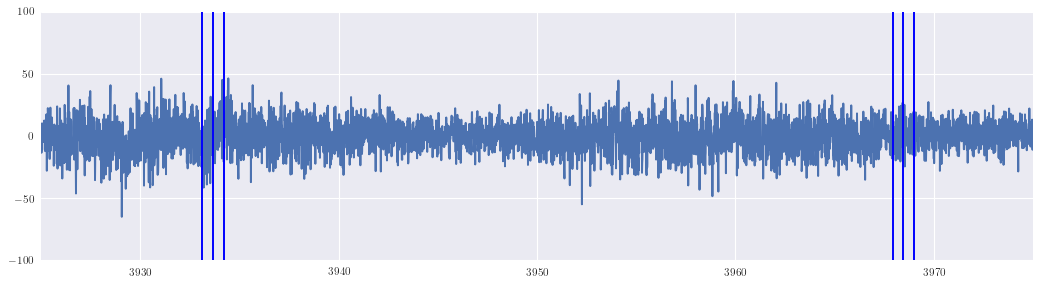

Spectra/GJ213/ADP.2014-10-06T10:04:28.040.fits  K flux negative:  -0.523351
Spectra/GJ213/ADP.2014-10-07T13:37:11.967.fits  K flux negative:  -0.170137
GJ213 1.0583e+15
GJ821 -5.827e+14
Spectra/GJ191/ADP.2014-10-06T10:06:54.180.fits  H flux negative:  -0.0505331
Spectra/GJ191/ADP.2014-10-06T10:06:54.180.fits  K flux negative:  -1.92669
Spectra/GJ191/ADP.2014-10-06T10:06:54.180.fits  V flux negative:  -1.31379
Spectra/GJ191/ADP.2014-10-06T10:06:54.180.fits  R flux negative:  -1.19029
GJ191 2.4519e+15
Spectra/GJ754.1B/ADP.2014-09-24T09:41:38.493.fits  K flux negative:  -1.11782
Spectra/GJ754.1B/ADP.2014-09-24T09:41:38.493.fits  S INDEX negative:  -0.00453007


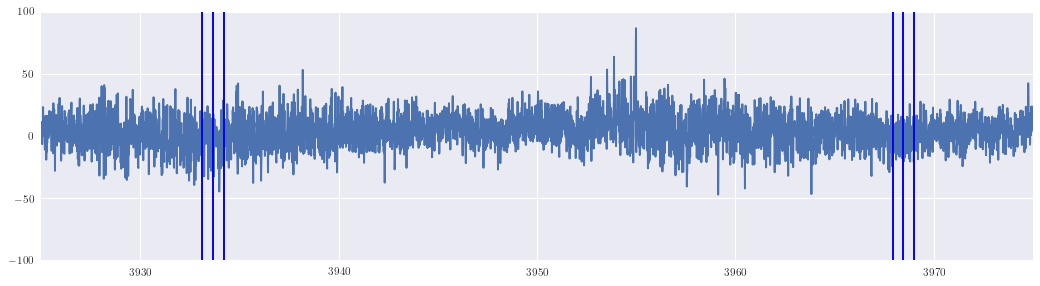

GJ754.1B 3.8513e+14
GJ388 1.25e+14
GJ803 -4.5e+13
Spectra/GJ551/ADP.2014-10-06T10:04:16.487.fits  V flux negative:  -0.892881
Spectra/GJ551/ADP.2014-10-06T10:04:27.513.fits  V flux negative:  -0.262379
Spectra/GJ551/ADP.2014-10-06T10:05:06.757.fits  V flux negative:  -0.703642
Spectra/GJ551/ADP.2014-10-06T10:05:24.987.fits  V flux negative:  -0.000602478
Spectra/GJ551/ADP.2014-10-06T10:05:36.187.fits  V flux negative:  -0.0303638
Spectra/GJ551/ADP.2014-10-06T10:05:47.317.fits  V flux negative:  -0.66663
Spectra/GJ551/ADP.2014-10-06T10:05:59.720.fits  V flux negative:  -0.12181
Spectra/GJ551/ADP.2014-10-06T10:06:04.100.fits  V flux negative:  -0.316743
Spectra/GJ551/ADP.2014-10-06T10:07:02.303.fits  V flux negative:  -0.257596
Spectra/GJ551/ADP.2014-10-06T10:07:06.063.fits  V flux negative:  -0.541746
Spectra/GJ551/ADP.2014-10-06T10:07:20.653.fits  V flux negative:  -0.421433
Spectra/GJ551/ADP.2014-10-06T10:07:30.743.fits  V flux negative:  -0.0546611
Spectra/GJ551/ADP.2014-10-06T10:07:

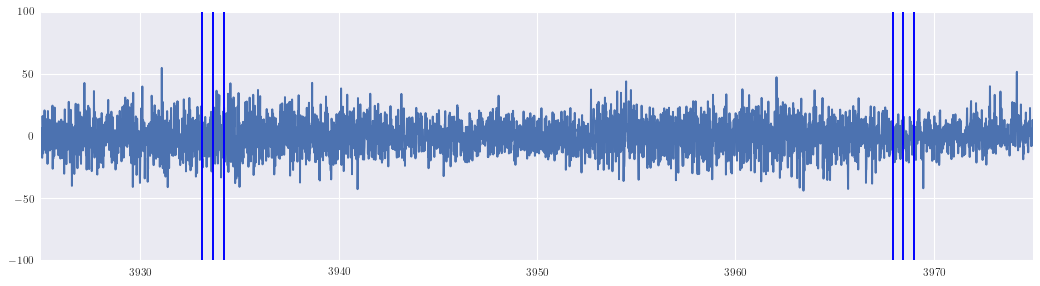

Spectra/GJ163/ADP.2014-09-26T16:52:17.783.fits  H flux negative:  -2.15522
Spectra/GJ163/ADP.2014-09-26T16:52:17.783.fits  K flux negative:  -0.849278
Spectra/GJ163/ADP.2014-09-26T16:52:17.783.fits  V flux negative:  -2.24533
Spectra/GJ163/ADP.2014-09-26T16:52:17.783.fits  R flux negative:  -2.42619
Spectra/GJ163/ADP.2014-09-26T16:53:07.233.fits  H flux negative:  -1.268
Spectra/GJ163/ADP.2014-09-26T16:53:07.233.fits  V flux negative:  -2.11686
Spectra/GJ163/ADP.2014-09-26T16:53:07.233.fits  R flux negative:  -2.41984
GJ163 5.81e+14
GJ849 -1.526e+14
GJ674 -2.73e+13
GJ699 -1.1051e+15
Spectra/GJ729/ADP.2017-09-04T01:01:08.669.fits  H flux negative:  -0.00124405
GJ729 -1.05e+14
GJ273 1.822e+14
GJ205 8.67e+13
Spectra/GJ588/ADP.2014-10-06T10:05:17.743.fits  K flux negative:  -0.771501
Spectra/GJ588/ADP.2014-10-06T10:06:54.560.fits  H flux negative:  -1.05743
Spectra/GJ588/ADP.2014-10-06T10:06:54.560.fits  K flux negative:  -2.1273
Spectra/GJ588/ADP.2014-10-06T10:06:54.560.fits  V flux negat

/Users/katiemel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in log10


In [136]:
star_names = np.genfromtxt("short_star_names.txt", dtype='str')

short_stars_rv = np.loadtxt("short_RVs.txt")
short_stars_photometry = np.loadtxt("short_photometry.txt")
#print(short_stars_rv)

stars_S_avgs = []
stars_S_avgs_err = []
stars_RHK_PRIME_avgs = []
stars_RHK_PRIME_avgs_err = []

for j in range(len(star_names)):
    
    #calculating stellar ccf (Astudillo-Defru 2017 equation 9 and table 1)
    #ALL COEFFS ARE FOR V-K COLOR
    ccf_c0 = -0.005
    ccf_c1 = 0.071
    ccf_c2 = -0.713 # +/- 0.006
    ccf_c3 = 0.973 # +/- 0.006
    
    R_c0 = -0.003
    R_c1 = 0.069
    R_c2 = -0.717 # +/- 0.003
    R_c3 = -3.498 # +/- 0.004
    
    V = short_stars_photometry[j][2]
    V_err = short_stars_photometry[j][3]
    K = short_stars_photometry[j][0]
    K_err = short_stars_photometry[j][1]
    V_K = V-K

    #QUESTION: should "log" in the paper mean natural log???
    Ccf = 10**(ccf_c0*(V_K)**3 + ccf_c1*(V_K)**2 + ccf_c2*(V_K) + ccf_c3)
    Rphot = 10**(R_c0*(V_K)**3 + R_c1*(V_K)**2 + R_c2*(V_K) + R_c3)
    #print(Rphot)

    spectra = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)

    all_S = []
    all_RHK_PRIME = []

    for i in range(len(spectra)):
        hdu = pyfits.open(spectra[i])

        wave = hdu[1].data[0][0] 
        flux = hdu[1].data[0][1]
        err = np.nan_to_num(hdu[1].data[0][2])
        #print("HARPS Error Array: ", err)

        #speed of light, target star RV, H-alpha in meters per second
        c = 299792458e10
        RV = short_stars_rv[j] * (10**13)
        
        wave = wave - (wave * RV / c)
        
        #THE FOLLOWING S INDEX IS BASED ON EQN 2 OF ASTUDILLO-DEFRU ET AL. 2017 (page 4)

        #fnding mean V continuum flux
        V_idx_cont = np.where((wave > (3901 - 10)) & (wave < (3901 + 10)))
        V_sub_cont = flux[V_idx_cont]
        V_err_cont = np.std(V_sub_cont)
        V_mean_cont = np.mean(V_sub_cont)
                              
        #finding mean K line flux
        K_idx_wave = np.array(np.where((wave > (3933.6614 - 1.09/.5)) & (wave < (3933.6614 + 1.09/.5))))
        K_sub_flux = flux[K_idx_wave]
        K_err_flux = err[K_idx_wave] 
        K_mean_flux = np.mean(K_sub_flux)
                              
        #finding mean H line flux
        H_idx_wave = np.array(np.where((wave > (3968.4673 - 1.09/.5)) & (wave < (3968.4673 + 1.09/.5))))
        H_sub_flux = flux[H_idx_wave]
        H_err_flux = err[H_idx_wave] 
        H_mean_flux = np.mean(H_sub_flux)
                                      
        #finding mean R continuum flux                      
        R_idx_cont = np.where(((wave > (4001 - 10)) & (wave < (4001 + 10))))
        R_sub_cont = flux[R_idx_cont]
        R_err_cont = np.std(R_sub_cont)
        R_mean_cont = np.mean(R_sub_cont)
                              
        #S INDEX!!!
        S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
        S = S_instrument_calibrated
        
        if H_mean_flux < 0.0:
            print(spectra[i], " H flux negative: ", H_mean_flux)
        if K_mean_flux < 0.0:
            print(spectra[i], " K flux negative: ", K_mean_flux)
        if V_mean_cont < 0.0:
            print(spectra[i], " V flux negative: ", V_mean_cont)
        if R_mean_cont < 0.0:
            print(spectra[i], " R flux negative: ", R_mean_cont)
        if S < 0.0:
            print(spectra[i], " S INDEX negative: ", S)
            #print(star_names[j])
            #print(RV)
            plt.figure(figsize=(16,4))
            plt.plot(wave,flux)
            #plt.xlim(3880,4020)
            #plt.xlim(3920,3940)
            plt.xlim(3925,3975)
            plt.ylim(-100,100)
            plt.axvline(3968.4673) #+ 3968.4673 * RV / c )
            plt.axvline(3968.4673 + 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3968.4673 - 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3933.6614) #+ 3933.6614 * RV / c )
            plt.axvline(3933.6614 + 1.09/2) # + 3933.6614 * RV / c )
            plt.axvline(3933.6614 - 1.09/2) # + 3933.6614 * RV / c )
            plt.show()
        
        #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
        Rhk = 1.887e-4 * Ccf * S
        #print(Rhk)
        RHK_PRIME = Rhk - Rphot
        #print(RHK_PRIME)
        
        #COLLECTING INFO FOR ALL SPECTRA OF A SINGLE STAR
        all_S.append(S)
        all_RHK_PRIME.append(RHK_PRIME)
    
    #AVERAGING CALCULATED INDEX VALUES FOR EACH STAR
    stars_S_avgs.append(np.mean(all_S))
    stars_S_avgs_err.append(np.std(all_S, ddof=1))
    stars_RHK_PRIME_avgs.append(np.mean(all_RHK_PRIME))
    stars_RHK_PRIME_avgs_err.append(np.std(all_RHK_PRIME, ddof=1))
    
    print(star_names[j], RV)

print("Star names: ", star_names)
print("S averages for each star: ", stars_S_avgs)
print("R'HK averages for each star: ", stars_RHK_PRIME_avgs)
print("log(R'HK) averages for each star: ", np.log10(stars_RHK_PRIME_avgs))

GJ588
1.55e+14


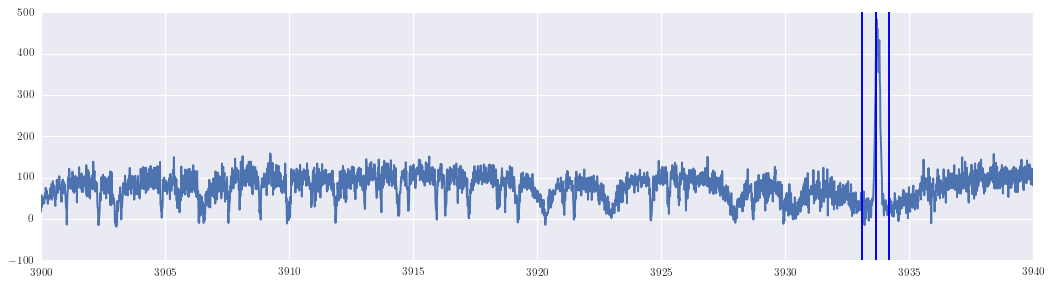

In [135]:
print(star_names[j])
print(RV)
plt.figure(figsize=(16,4))
plt.plot(wave,flux)
#plt.xlim(3880,4020)
#plt.xlim(3920,3940)
plt.xlim(3900,3940)
plt.ylim(-100,500)
plt.axvline(3968.4673) #+ 3968.4673 * RV / c )
plt.axvline(3968.4673 + 1.09/2) #+ 3968.4673 * RV / c )
plt.axvline(3968.4673 - 1.09/2) #+ 3968.4673 * RV / c )
plt.axvline(3933.6614) #+ 3933.6614 * RV / c )
plt.axvline(3933.6614 + 1.09/2) #+ 3933.6614 * RV / c )
plt.axvline(3933.6614 - 1.09/2) #+ 3933.6614 * RV / c )

In [138]:
output = np.column_stack((stars_S_avgs, stars_S_avgs_err,  stars_RHK_PRIME_avgs, stars_RHK_PRIME_avgs_err))
np.savetxt("Results/short_cahk_s_rhk.txt", output)

# HIRES ONLY

In [ ]:
star_names = np.genfromtxt("short_star_names.txt", dtype='str')

short_stars_rv = np.loadtxt("short_RVs.txt")
short_stars_photometry = np.loadtxt("short_photometry.txt")
#print(short_stars_rv)

stars_S_avgs = []
stars_S_avgs_err = []
stars_RHK_PRIME_avgs = []
stars_RHK_PRIME_avgs_err = []

for j in range(len(star_names)):
    
    #calculating stellar ccf (Astudillo-Defru 2017 equation 9 and table 1)
    #ALL COEFFS ARE FOR V-K COLOR
    ccf_c0 = -0.005
    ccf_c1 = 0.071
    ccf_c2 = -0.713 # +/- 0.006
    ccf_c3 = 0.973 # +/- 0.006
    
    R_c0 = -0.003
    R_c1 = 0.069
    R_c2 = -0.717 # +/- 0.003
    R_c3 = -3.498 # +/- 0.004
    
    V = short_stars_photometry[j][2]
    V_err = short_stars_photometry[j][3]
    K = short_stars_photometry[j][0]
    K_err = short_stars_photometry[j][1]
    V_K = V-K

    #QUESTION: should "log" in the paper mean natural log???
    Ccf = 10**(ccf_c0*(V_K)**3 + ccf_c1*(V_K)**2 + ccf_c2*(V_K) + ccf_c3)
    Rphot = 10**(R_c0*(V_K)**3 + R_c1*(V_K)**2 + R_c2*(V_K) + R_c3)
    #print(Rphot)

    spectra = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)

    all_S = []
    all_RHK_PRIME = []

    for i in range(len(spectra)):
        hdu = pyfits.open(spectra[i])

        wave = hdu[1].data[0][0] 
        flux = hdu[1].data[0][1]
        err = np.nan_to_num(hdu[1].data[0][2])
        #print("HARPS Error Array: ", err)

        #speed of light, target star RV, H-alpha in meters per second
        c = 299792458e10
        RV = short_stars_rv[j] * (10**13)
        
        wave = wave - (wave * RV / c)
        
        #THE FOLLOWING S INDEX IS BASED ON EQN 2 OF ASTUDILLO-DEFRU ET AL. 2017 (page 4)

        #fnding mean V continuum flux
        V_idx_cont = np.where((wave > (3901 - 10)) & (wave < (3901 + 10)))
        V_sub_cont = flux[V_idx_cont]
        V_err_cont = np.std(V_sub_cont)
        V_mean_cont = np.mean(V_sub_cont)
                              
        #finding mean K line flux
        K_idx_wave = np.array(np.where((wave > (3933.6614 - 1.09/.5)) & (wave < (3933.6614 + 1.09/.5))))
        K_sub_flux = flux[K_idx_wave]
        K_err_flux = err[K_idx_wave] 
        K_mean_flux = np.mean(K_sub_flux)
                              
        #finding mean H line flux
        H_idx_wave = np.array(np.where((wave > (3968.4673 - 1.09/.5)) & (wave < (3968.4673 + 1.09/.5))))
        H_sub_flux = flux[H_idx_wave]
        H_err_flux = err[H_idx_wave] 
        H_mean_flux = np.mean(H_sub_flux)
                                      
        #finding mean R continuum flux                      
        R_idx_cont = np.where(((wave > (4001 - 10)) & (wave < (4001 + 10))))
        R_sub_cont = flux[R_idx_cont]
        R_err_cont = np.std(R_sub_cont)
        R_mean_cont = np.mean(R_sub_cont)
                              
        #S INDEX!!!
        S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
        S = S_instrument_calibrated
        
        if H_mean_flux < 0.0:
            print(spectra[i], " H flux negative: ", H_mean_flux)
        if K_mean_flux < 0.0:
            print(spectra[i], " K flux negative: ", K_mean_flux)
        if V_mean_cont < 0.0:
            print(spectra[i], " V flux negative: ", V_mean_cont)
        if R_mean_cont < 0.0:
            print(spectra[i], " R flux negative: ", R_mean_cont)
        if S < 0.0:
            print(spectra[i], " S INDEX negative: ", S)
            #print(star_names[j])
            #print(RV)
            plt.figure(figsize=(16,4))
            plt.plot(wave,flux)
            #plt.xlim(3880,4020)
            #plt.xlim(3920,3940)
            plt.xlim(3925,3975)
            plt.ylim(-100,100)
            plt.axvline(3968.4673) #+ 3968.4673 * RV / c )
            plt.axvline(3968.4673 + 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3968.4673 - 1.09/2) # + 3968.4673 * RV / c )
            plt.axvline(3933.6614) #+ 3933.6614 * RV / c )
            plt.axvline(3933.6614 + 1.09/2) # + 3933.6614 * RV / c )
            plt.axvline(3933.6614 - 1.09/2) # + 3933.6614 * RV / c )
            plt.show()
        
        #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
        Rhk = 1.887e-4 * Ccf * S
        #print(Rhk)
        RHK_PRIME = Rhk - Rphot
        #print(RHK_PRIME)
        
        #COLLECTING INFO FOR ALL SPECTRA OF A SINGLE STAR
        all_S.append(S)
        all_RHK_PRIME.append(RHK_PRIME)
    
    #AVERAGING CALCULATED INDEX VALUES FOR EACH STAR
    stars_S_avgs.append(np.mean(all_S))
    stars_S_avgs_err.append(np.std(all_S, ddof=1))
    stars_RHK_PRIME_avgs.append(np.mean(all_RHK_PRIME))
    stars_RHK_PRIME_avgs_err.append(np.std(all_RHK_PRIME, ddof=1))
    
    print(star_names[j], RV)

print("Star names: ", star_names)
print("S averages for each star: ", stars_S_avgs)
print("R'HK averages for each star: ", stars_RHK_PRIME_avgs)
print("log(R'HK) averages for each star: ", np.log10(stars_RHK_PRIME_avgs))

## BELOW THIS DON'T CHANGE!

In [118]:
#OLD!!! KEEP THIS WAY!!

star_names = np.genfromtxt("short_star_names.txt", dtype='str')

short_stars_rv = np.loadtxt("short_RVs.txt")
short_stars_photometry = np.loadtxt("short_photometry.txt")
#print(short_stars_rv)

stars_S_avgs = []
stars_S_avgs_err = []
stars_RHK_PRIME_avgs = []
stars_RHK_PRIME_avgs_err = []

for j in range(len(star_names)):
    
    print(star_names[j])
    
    #calculating stellar ccf (Astudillo-Defru 2017 equation 9 and table 1)
    #ALL COEFFS ARE FOR V-K COLOR
    ccf_c0 = -0.005
    ccf_c1 = 0.071
    ccf_c2 = -0.713 # +/- 0.006
    ccf_c3 = 0.973 # +/- 0.006
    
    R_c0 = -0.003
    R_c1 = 0.069
    R_c2 = -0.717 # +/- 0.003
    R_c3 = -3.498 # +/- 0.004
    
    V = short_stars_photometry[j][2]
    V_err = short_stars_photometry[j][3]
    K = short_stars_photometry[j][0]
    K_err = short_stars_photometry[j][1]
    V_K = V-K

    #QUESTION: should "log" in the paper mean natural log???
    Ccf = 10**(ccf_c0*(V_K)**3 + ccf_c1*(V_K)**2 + ccf_c2*(V_K) + ccf_c3)
    Rphot = 10**(R_c0*(V_K)**3 + R_c1*(V_K)**2 + R_c2*(V_K) + R_c3)
    #print(Rphot)

    spectra = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum)

    all_S = []
    all_RHK_PRIME = []

    for i in range(len(spectra)):
        hdu = pyfits.open(spectra[i])

        wave = hdu[1].data[0][0] 
        flux = hdu[1].data[0][1]
        err = np.nan_to_num(hdu[1].data[0][2])
        #print("HARPS Error Array: ", err)

        #speed of light, target star RV, H-alpha in meters per second
        c = 299792458
        CaH = 3968e-10
        CaK = 3934e-10
        RV = short_stars_rv[j] * (10 ** 3)
        #RV_conv = 0
        RV_conv_H = (CaH * RV / c) * (10 ** 10)
        RV_conv_K = (CaK * RV / c) * (10 ** 10)
        
        #accounting for target star RV conversion in angstroms
        #RV given in SIMBAD (note: HARPS already corrects for movement of earth)
        """sub = np.where((wave > 6558.8) & (wave < 6566.8))
        find_min = np.argmin(flux[sub])
        sub_wave = wave[sub]
        find_wave_at_min = sub_wave[find_min]
        #print(find_wave_at_min)
        RV_conv = find_wave_at_min-6562.8
        #print(RV_conv)"""
        
        #THE FOLLOWING S INDEX IS BASED ON EQN 2 OF ASTUDILLO-DEFRU ET AL. 2017 (page 4)

        #fnding mean V continuum flux
        cont_3901 = 3901 + RV_conv_K
        V_idx_cont = np.where((wave > (cont_3901 - 10)) & (wave < (cont_3901 + 10)))
        V_sub_cont = flux[V_idx_cont]
        V_err_cont = np.std(V_sub_cont)
        V_mean_cont = np.mean(V_sub_cont)
                              
        #finding mean K line flux
        K_idx_wave = np.array(np.where((wave > (3934 - 1.09/.5 + RV_conv_K)) & (wave < (3934 + 1.09/.5 + RV_conv_K))))
        K_sub_flux = flux[K_idx_wave]
        K_err_flux = err[K_idx_wave] 
        K_mean_flux = np.mean(K_sub_flux)
                              
        #finding mean H line flux
        H_idx_wave = np.array(np.where((wave > (3968 - 1.09/.5 + RV_conv_H)) & (wave < (3968 + 1.09/.5 + RV_conv_H))))
        H_sub_flux = flux[H_idx_wave]
        H_err_flux = err[H_idx_wave] 
        H_mean_flux = np.mean(H_sub_flux)
                                      
        #finding mean R continuum flux                      
        cont_4001 = 4001 + RV_conv_H
        R_idx_cont = np.where(((wave > (cont_4001 - 10)) & (wave < (cont_4001 + 10))))
        R_sub_cont = flux[R_idx_cont]
        R_err_cont = np.std(R_sub_cont)
        R_mean_cont = np.mean(R_sub_cont)
                              
        #S INDEX!!!
        S_instrument_calibrated = (H_mean_flux + K_mean_flux) / (V_mean_cont + R_mean_cont)
        S = 1.053 * S_instrument_calibrated + 0.026
        
        if H_mean_flux < 0.0:
            print(spectra[i], " H flux negative: ", H_mean_flux)
        if K_mean_flux < 0.0:
            print(spectra[i], " K flux negative: ", K_mean_flux)
        if V_mean_cont < 0.0:
            print(spectra[i], " V flux negative: ", V_mean_cont)
        if R_mean_cont < 0.0:
            print(spectra[i], " R flux negative: ", R_mean_cont)
        
        #THE FOLLOWING R'HK INDEX IS BASED ON ASTUDILLO-DEFRU ET AL. 2017 EQNS 4, 9, 11, AND TABLE 1
        Rhk = 1.887e-4 * Ccf * S
        #print(Rhk)
        RHK_PRIME = Rhk - Rphot
        #print(RHK_PRIME)
        
        #COLLECTING INFO FOR ALL SPECTRA OF A SINGLE STAR
        all_S.append(S)
        all_RHK_PRIME.append(RHK_PRIME)
    
    #AVERAGING CALCULATED INDEX VALUES FOR EACH STAR
    stars_S_avgs.append(np.mean(all_S))
    stars_S_avgs_err.append(np.std(all_S, ddof=1))
    stars_RHK_PRIME_avgs.append(np.mean(all_RHK_PRIME))
    stars_RHK_PRIME_avgs_err.append(np.std(all_RHK_PRIME, ddof=1))

print("Star names: ", star_names)
print("S averages for each star: ", stars_S_avgs)
print("R'HK averages for each star: ", stars_RHK_PRIME_avgs)
print("log(R'HK) averages for each star: ", np.log10(stars_RHK_PRIME_avgs))

GJ176
GJ667C


KeyboardInterrupt: 

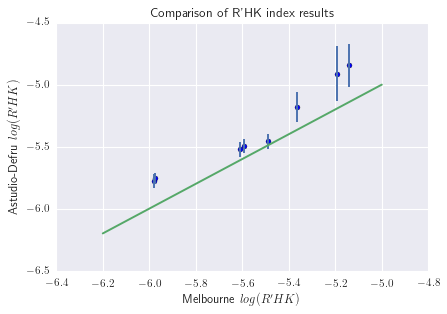

In [11]:
#Graph of my values versus Astudillo-Defru values of R'HK listed in VizieR
#IS THERE A WAY TO QUERY THIS FOR ALL OVERLAP BETWEEN THEIR SAMPLE AND OURS???
ad_rhk = np.array([-4.911, -5.776, -5.182, -5.496, -5.457, -5.523, -4.843, -5.754])
ad_rkh_err = np.array([0.22, 0.057, 0.122, 0.057, 0.062, 0.06, 0.173, 0.045])
my_rhk = np.array([-5.193, -5.979, -5.366, -5.592, -5.490, -5.609, -5.139, -5.977])

plt.scatter(my_rhk, ad_rhk)
plt.errorbar(my_rhk, ad_rhk, yerr=ad_rkh_err, linestyle="None")
plt.plot(np.linspace(-5,-6.2),np.linspace(-5,-6.2))
plt.title("Comparison of R'HK index results")
plt.xlabel("Melbourne $log(R'HK)$")
plt.ylabel("Astudio-Defru $log(R'HK)$")

#NEED MORE POINTS!!!